# 0. Chemin

In [1]:
import os

In [2]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [3]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [4]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [5]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 1. Telecharger lesmodels Tensorflow preentrainer et installation de TFOD

In [6]:
if os.name=='nt':
    !pip install wget
    import wget

In [7]:
import object_detection

# 2. Creation de Label Map

In [8]:
labels = [{'name':'licence', 'id':1}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 5. Mettre a jour les Configurations pour le Transfer Learning

In [9]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

# 8. Lancer le Model entrainer

In [10]:
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

In [11]:
# GPU config
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try: 
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RunTimeError as e:
        
        print(e)

In [12]:
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restoration du checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-11')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 9. Detection d'une Image

In [13]:
import cv2
import numpy as np
import easyocr
from matplotlib import pyplot as plt
%matplotlib inline
region_threshold = 0.7
detection_threshold = 0.7

In [14]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [15]:
def filter_text(region, ocr_result, region_threshold):
    rectangle_size = region.shape[0]*region.shape[1]
    
    plate = [] 
    for result in ocr_result:
        length = np.sum(np.subtract(result[0][1], result[0][0]))
        height = np.sum(np.subtract(result[0][2], result[0][1]))
        
        if length*height / rectangle_size > region_threshold:
            plate.append(result[1])
    return plate

In [16]:
def ocr_it(image, detections, detection_threshold, region_threshold):
    
    # Scores, boxes and classes above threhold
    scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
    boxes = detections['detection_boxes'][:len(scores)]
    classes = detections['detection_classes'][:len(scores)]
    
    # Full image dimensions
    width = image.shape[1]
    height = image.shape[0]
    
    # Apply ROI filtering and OCR
    for idx, box in enumerate(boxes):
        roi = box*[height, width, height, width]
        region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        reader = easyocr.Reader(['en'])
        ocr_result = reader.readtext(region)
        
        text = filter_text(region, ocr_result, region_threshold)
        
        plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
        plt.show()
        print(text)
        return text, region

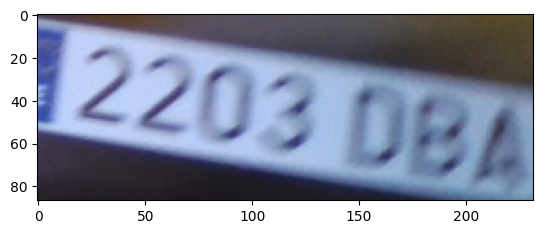

[]


{'message': 'Image URL stored successfully'}


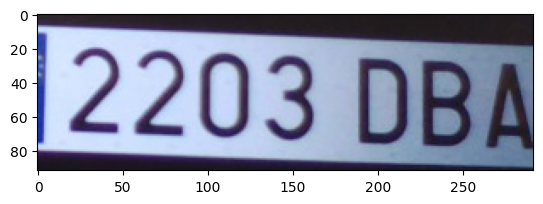

['2203 DBA']


{'message': 'Image URL stored successfully'}


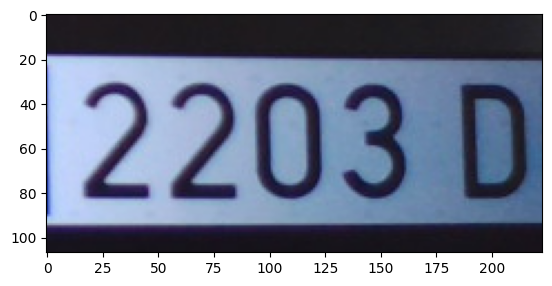

[]
{'message': 'Image URL stored successfully'}


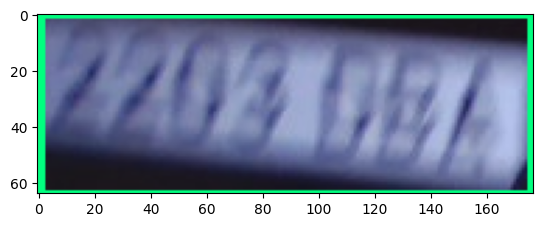

[]


{'message': 'Image URL stored successfully'}


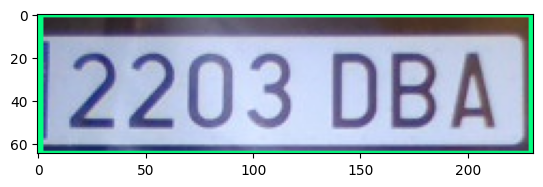

[]


{'message': 'Image URL stored successfully'}


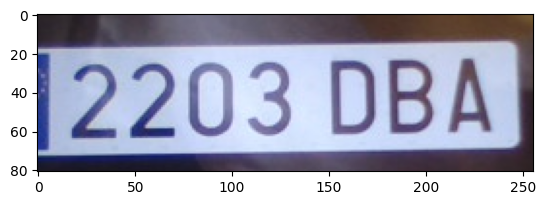

[]


{'message': 'Image URL stored successfully'}


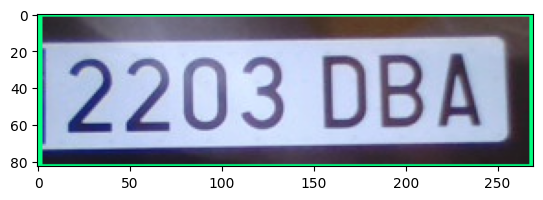

[]


{'message': 'Image URL stored successfully'}


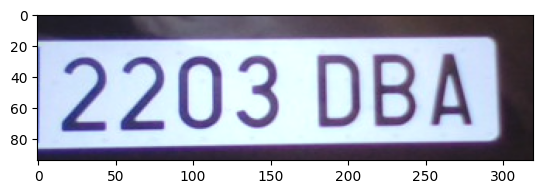

[]


{'message': 'Image URL stored successfully'}


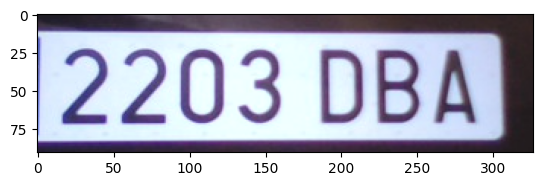

[]


{'message': 'Image URL stored successfully'}


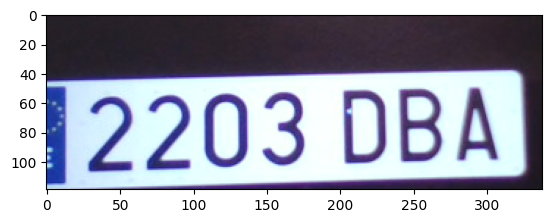

[]


{'message': 'Image URL stored successfully'}


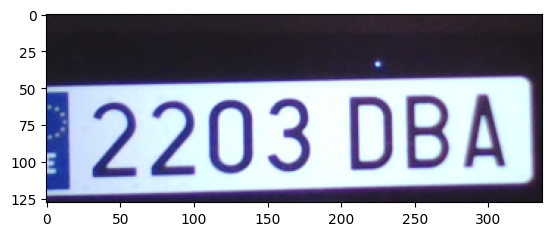

[]


{'message': 'Image URL stored successfully'}


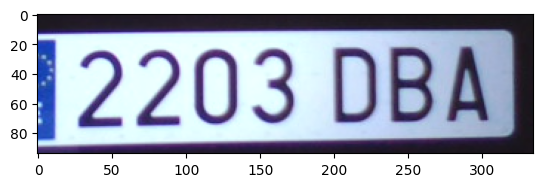

[]


{'message': 'Image URL stored successfully'}


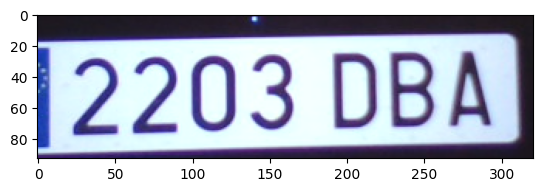

['2203 DBA']
{'message': 'Image URL stored successfully'}


In [18]:
import httpx
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    #requette
    
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)
    try:
        text, region = ocr_it(image_np_with_detections, detections, detection_threshold, region_threshold)
        if not text:
            ity = "Mbola tsisy"
            api_url = "http://localhost:8080/post_test/"
            response = httpx.post(api_url, json={"test": ity})
            print(response.json())
        else:
            ityy = "indro ary"
            api_url = "http://localhost:8080/post_test/"
            response = httpx.post(api_url, json={"test": ityy})
            print(response.json())
    except:
        pass
    
    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

# Requette

In [ ]:
import requests
import mysql.connector

# Établir la connexion à la base de données
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="",
    database="plate"
)
cursor = conn.cursor()

for id_value in text:
    try:
        #proprietaire
        query1 = "SELECT * FROM proprietaire WHERE id = %s"
        cursor.execute(query1, (id_value,))
        result1 = cursor.fetchall()

        #casier
        query2 = "SELECT casier.* FROM casier JOIN proprietaire ON casier.nom = proprietaire.nom WHERE proprietaire.id = %s"
        cursor.execute(query2, (id_value,))
        result2 = cursor.fetchall()

        #voiture
        query3 = "SELECT * FROM voiture WHERE id = %s"
        cursor.execute(query3, (id_value,))
        result3 = cursor.fetchall()

        #servise routiere
        query4 = "SELECT * FROM serviceroutiere WHERE id = %s"
        cursor.execute(query4, (id_value,))
        result4 = cursor.fetchall()

        resultat = result1 + result2 + result3 + result4
        response = requests.post('http://localhost:8000/post_results', json={"data": resultat})
        print(response.json())

    except Exception as e:
        print(f"Erreur: {e}")

# Fermeture des connexions
cursor.close()
conn.close()

# Sauvegarder le resultat

In [ ]:
import csv
import uuid

In [ ]:
'{}.png'.format(uuid.uuid1())

In [ ]:
def save_results(text, region, csv_filename, folder_path):
    img_name = '{}.jpg'.format(uuid.uuid1())
    
    cv2.imwrite(os.path.join(folder_path, img_name), region)
    
    with open(csv_filename, mode='a', newline='') as f:
        csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerow([img_name, text])
        

In [ ]:
save_results(text, region, 'detection_results.csv', 'Detection_Images')